In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn import preprocessing, tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus 
from sklearn import metrics
from IPython.display import Image 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Decision tree > Getting FUND

In [2]:
df=pd.read_json('../01_Preprocessing/Second.json').sort_index()

In [3]:
df.head(2)

,country,countryCode,degree,degreeCode,eng,field,fieldG_0,fieldG_1,fieldG_10,fieldG_11,...,greQ,greV,greW,highBU,highMU,paper,rejUni,targetUni,uniRank,year
2,united kingdom,4,Doctorate,1,8.0,petroleum engineering,False,False,False,False,...,NaN,NaN,NaN,False,False,7,n/a,heriot-watt,692.0,2007
3,united states,0,Doctorate,1,8.0,civil,False,False,False,False,...,159.0,143.0,3.0,True,False,11,"UC Berkeley, Georgia Tech",northwestern,20.0,2010


In [4]:
df.columns

Index([u'country', u'countryCode', u'degree', u'degreeCode', u'eng', u'field',
       u'fieldG_0', u'fieldG_1', u'fieldG_10', u'fieldG_11', u'fieldG_12',
       u'fieldG_13', u'fieldG_14', u'fieldG_15', u'fieldG_16', u'fieldG_17',
       u'fieldG_18', u'fieldG_2', u'fieldG_3', u'fieldG_4', u'fieldG_5',
       u'fieldG_6', u'fieldG_7', u'fieldG_8', u'fieldG_9', u'fieldGroup',
       u'fund', u'fundValue', u'gpaB', u'gpaM', u'gre', u'greQ', u'greV',
       u'greW', u'highBU', u'highMU', u'paper', u'rejUni', u'targetUni',
       u'uniRank', u'year'],
      dtype='object')

In [5]:
df.uniRank.fillna(300,inplace=True)
df.greQ.fillna(0,inplace=True)
df.greW.fillna(0,inplace=True)
df.greV.fillna(0,inplace=True)

# FUNCTIONS

In [6]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)

In [7]:
def build3(xtr, ytr,xte,yte,rocEnable,max_depth,criterion='entropy',class_weight=None):
    clf = DecisionTreeClassifier(criterion = criterion, random_state = 100, max_depth=max_depth,class_weight=class_weight)
    clf.fit(xtr, ytr)
    ypred = clf.predict(xte)
    if rocEnable==False:
        acc=accuracy_score(yte,ypred)*100
    else:
        fpr, tpr, thresholds = metrics.roc_curve(yte,ypred)
        acc=metrics.auc(fpr, tpr)*100
    conf=confusion_matrix(yte,ypred)
    return (clf,acc,conf)
def draw3(clf):
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names=col,  max_depth=3, rounded=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())  

# DTree Fund For PHD Students

In [8]:
col=['countryCode', 'eng',
       'fieldG_0', 'fieldG_1', 'fieldG_10', 'fieldG_11', 'fieldG_12',
       'fieldG_13', 'fieldG_14', 'fieldG_15', 'fieldG_16', 'fieldG_17',
       'fieldG_18', 'fieldG_2', 'fieldG_3', 'fieldG_4', 'fieldG_5',
       'fieldG_6', 'fieldG_7', 'fieldG_8', 'fieldG_9',
       'gpaB', 'gpaM', 'gre', 'greQ', 'greV', 'greW', 
       'highBU', 'highMU', 'paper', 'uniRank']

In [9]:
data=df[df.degreeCode==1][col]
target=df[df.degreeCode==1].fund
xtr,xte,ytr,yte=train_test_split(data,target,test_size=0.3 ,random_state=99)

In [10]:
data.head(2)

,countryCode,eng,fieldG_0,fieldG_1,fieldG_10,fieldG_11,fieldG_12,fieldG_13,fieldG_14,fieldG_15,...,gpaB,gpaM,gre,greQ,greV,greW,highBU,highMU,paper,uniRank
2,4,8.0,False,False,False,False,False,False,False,False,...,3.5,3.442986,False,0.0,0.0,0.0,False,False,7,692.0
3,0,8.0,False,False,False,False,False,False,False,False,...,2.5,3.500000,True,159.0,143.0,3.0,True,False,11,20.0


In [11]:
print(xtr.shape,ytr.shape,xte.shape,yte.shape)

((1241, 31), (1241L,), (532, 31), (532L,))


# PHD + AUC + train_test_split

In [12]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [13]:
[max(ac),ac.index(max(ac))]

[61.027327019364172, 19]

In [14]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 2, 1: 1}, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [15]:
# draw3(clf) 

# PHD + Acc + train_test_split

In [16]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [17]:
[max(ac),ac.index(max(ac))]

[79.135338345864653, 651]

In [18]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [19]:
# get_code(clf,col)

# PHD + Acc + train_test_split + NoWeight

In [20]:
ac=[];clfs=[]
for i in range(3,10):
    for k in ['entropy','gini']:
        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k)
        ac.append(acc)
        clfs.append(clf)

In [21]:
[max(ac),ac.index(max(ac))]

[78.007518796992485, 5]

In [22]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [23]:
# draw3(clf)

In [24]:
# get_code(clf,col)

# PHD + AUC + StratifiedKFold

In [25]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [26]:
[max(ac),ac.index(max(ac))]

[68.759689922480632, 965]

In [27]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 2, 1: 3}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

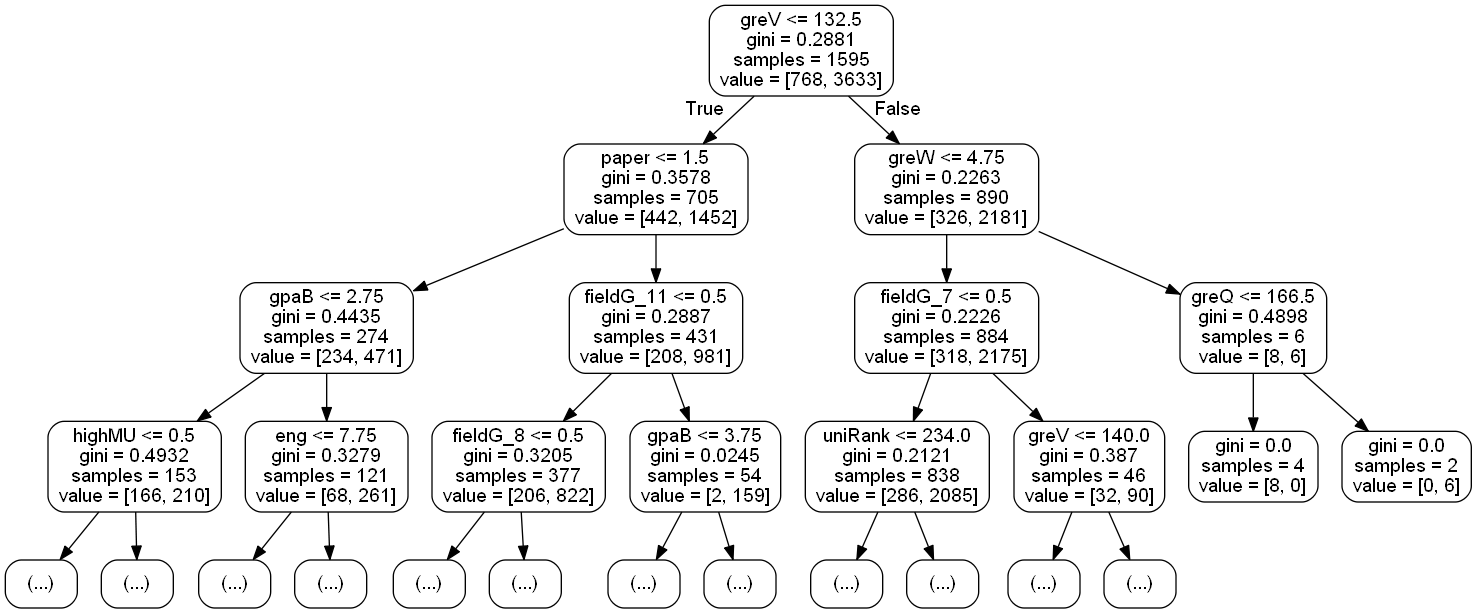

In [28]:
draw3(clf)

In [29]:
get_code(clf,col)

if ( greV <= 132.5 ) {
if ( paper <= 1.5 ) {
if ( gpaB <= 2.75 ) {
if ( highMU <= 0.5 ) {
if ( uniRank <= 273.0 ) {
if ( uniRank <= 62.5 ) {
return [[ 6.  0.]]
} else {
if ( gpaB <= 1.25 ) {
return [[ 2.  0.]]
} else {
return [[  6.  33.]]
}
}
} else {
if ( uniRank <= 406.0 ) {
if ( countryCode <= 6.5 ) {
return [[ 90.  39.]]
} else {
return [[ 0.  6.]]
}
} else {
if ( eng <= 6.75 ) {
return [[ 8.  3.]]
} else {
return [[  4.  24.]]
}
}
}
} else {
if ( gpaM <= 2.25 ) {
return [[ 4.  0.]]
} else {
if ( fieldG_0 <= 0.5 ) {
if ( gpaB <= 1.75 ) {
return [[  0.  18.]]
} else {
return [[ 28.  69.]]
}
} else {
if ( uniRank <= 330.5 ) {
return [[ 18.  12.]]
} else {
return [[ 0.  6.]]
}
}
}
}
} else {
if ( eng <= 7.75 ) {
if ( eng <= 6.75 ) {
if ( gpaM <= 3.75 ) {
if ( fieldG_2 <= 0.5 ) {
return [[  6.  36.]]
} else {
return [[ 2.  0.]]
}
} else {
if ( fieldG_3 <= 0.5 ) {
return [[ 8.  3.]]
} else {
return [[ 0.  3.]]
}
}
} else {
if ( gpaM <= 2.0 ) {
return [[ 2.  0.]]
} else {
if ( fieldG_8 

In [30]:
confs[ac.index(max(ac))]

array([[ 19,  24],
       [  9, 126]])

# {0:3, 1: 2} ACC

In [31]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:3, 1: 2})
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [32]:
[max(ac),ac.index(max(ac))]

[80.11363636363636, 94]

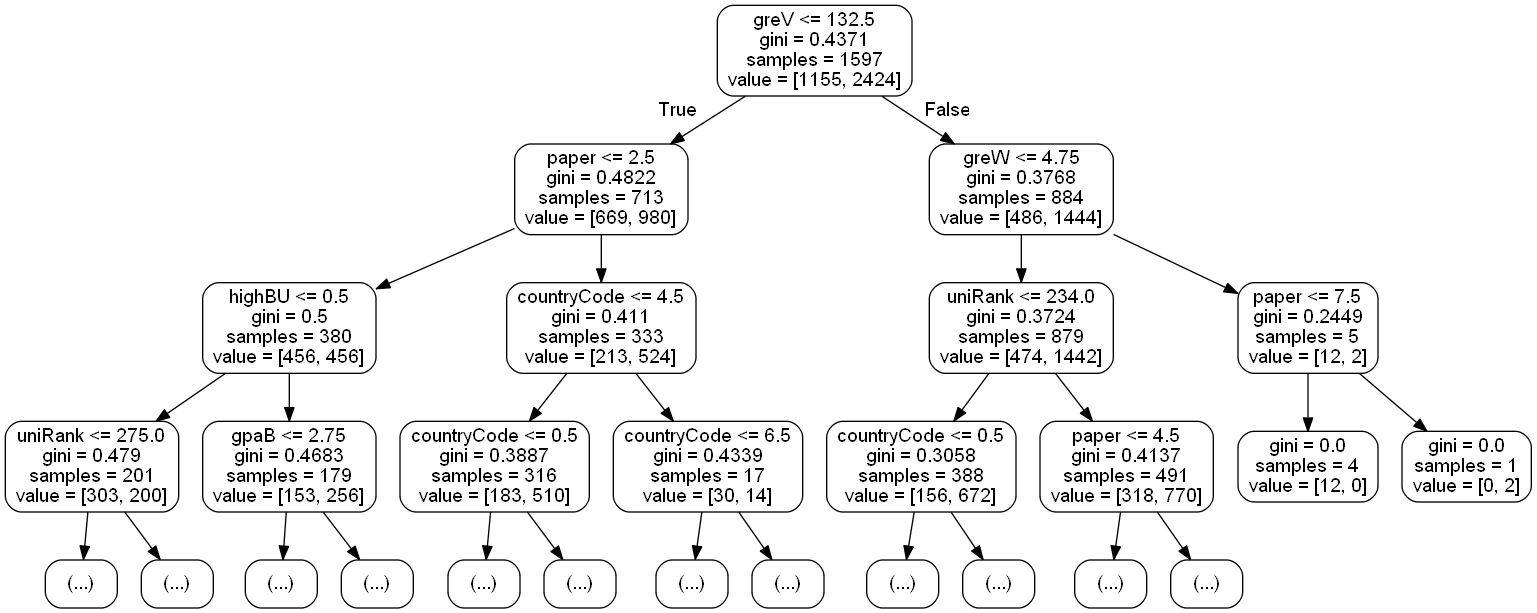

In [33]:
draw3(clf)

In [34]:
clf

DecisionTreeClassifier(class_weight={0: 3, 1: 2}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [35]:
get_code(clf,col)

if ( greV <= 132.5 ) {
if ( paper <= 2.5 ) {
if ( highBU <= 0.5 ) {
if ( uniRank <= 275.0 ) {
if ( uniRank <= 73.0 ) {
if ( fieldG_1 <= 0.5 ) {
if ( fieldG_10 <= 0.5 ) {
return [[ 36.   6.]]
} else {
return [[ 0.  4.]]
}
} else {
return [[ 0.  6.]]
}
} else {
if ( uniRank <= 210.0 ) {
if ( gpaM <= 3.47149276733 ) {
return [[ 18.  16.]]
} else {
return [[  3.  26.]]
}
} else {
return [[  0.  32.]]
}
}
} else {
if ( uniRank <= 322.0 ) {
if ( fieldG_11 <= 0.5 ) {
if ( countryCode <= 3.5 ) {
return [[ 174.   32.]]
} else {
return [[ 18.  18.]]
}
} else {
if ( paper <= 0.5 ) {
return [[ 9.  4.]]
} else {
return [[ 0.  8.]]
}
}
} else {
if ( uniRank <= 575.0 ) {
if ( gpaB <= 1.25 ) {
return [[ 3.  0.]]
} else {
return [[  6.  34.]]
}
} else {
if ( eng <= 6.75 ) {
return [[ 21.   0.]]
} else {
return [[ 15.  14.]]
}
}
}
}
} else {
if ( gpaB <= 2.75 ) {
if ( fieldG_5 <= 0.5 ) {
if ( countryCode <= 5.5 ) {
if ( uniRank <= 314.5 ) {
return [[ 69.  86.]]
} else {
return [[  9.  38.]]
}
} else {
i

# PHD + ACC + StratifiedKFold

In [36]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [37]:
[max(ac),ac.index(max(ac))]

[81.460674157303373, 965]

In [38]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 2, 1: 3}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

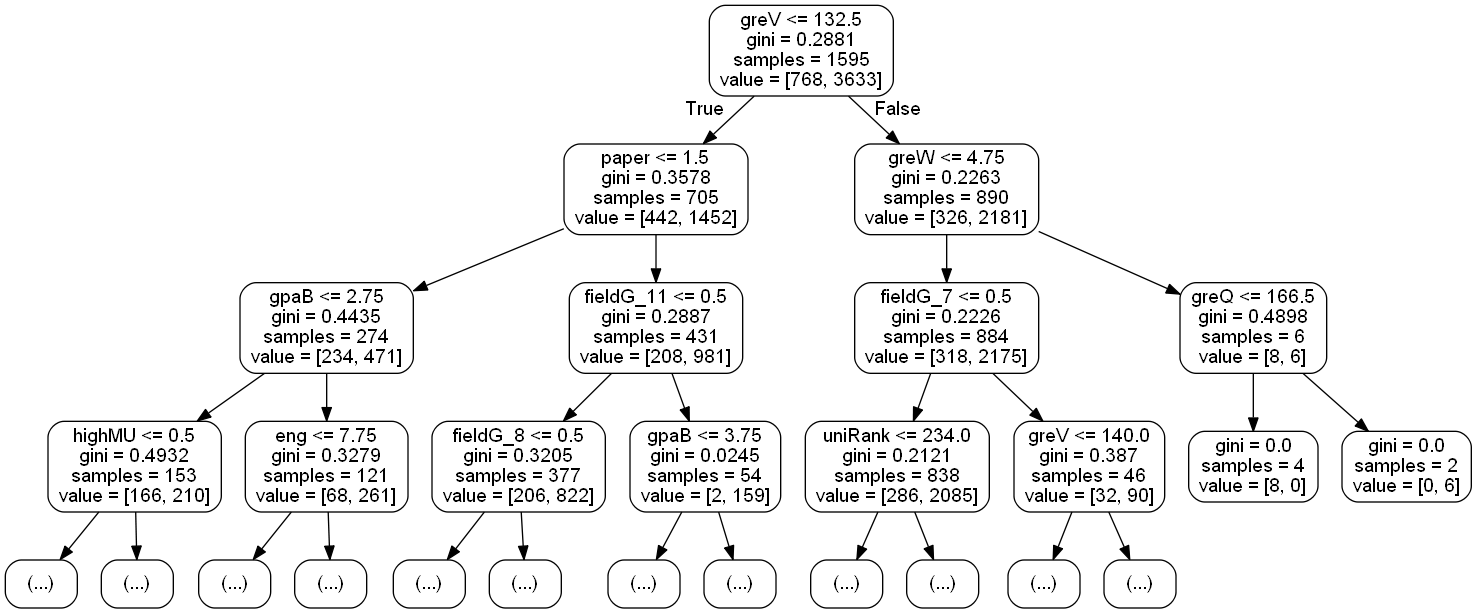

In [39]:
draw3(clf)

In [40]:
get_code(clf,col)

if ( greV <= 132.5 ) {
if ( paper <= 1.5 ) {
if ( gpaB <= 2.75 ) {
if ( highMU <= 0.5 ) {
if ( uniRank <= 273.0 ) {
if ( uniRank <= 62.5 ) {
return [[ 6.  0.]]
} else {
if ( gpaB <= 1.25 ) {
return [[ 2.  0.]]
} else {
return [[  6.  33.]]
}
}
} else {
if ( uniRank <= 406.0 ) {
if ( countryCode <= 6.5 ) {
return [[ 90.  39.]]
} else {
return [[ 0.  6.]]
}
} else {
if ( eng <= 6.75 ) {
return [[ 8.  3.]]
} else {
return [[  4.  24.]]
}
}
}
} else {
if ( gpaM <= 2.25 ) {
return [[ 4.  0.]]
} else {
if ( fieldG_0 <= 0.5 ) {
if ( gpaB <= 1.75 ) {
return [[  0.  18.]]
} else {
return [[ 28.  69.]]
}
} else {
if ( uniRank <= 330.5 ) {
return [[ 18.  12.]]
} else {
return [[ 0.  6.]]
}
}
}
}
} else {
if ( eng <= 7.75 ) {
if ( eng <= 6.75 ) {
if ( gpaM <= 3.75 ) {
if ( fieldG_2 <= 0.5 ) {
return [[  6.  36.]]
} else {
return [[ 2.  0.]]
}
} else {
if ( fieldG_3 <= 0.5 ) {
return [[ 8.  3.]]
} else {
return [[ 0.  3.]]
}
}
} else {
if ( gpaM <= 2.0 ) {
return [[ 2.  0.]]
} else {
if ( fieldG_8 

In [41]:
confs[ac.index(max(ac))]

array([[ 19,  24],
       [  9, 126]])

# PHD + ACC + StratifiedKFold + BALANCED

In [42]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [43]:
[max(ac),ac.index(max(ac))]

[76.404494382022463, 7]

# PHD + AUC + StratifiedKFold + BALANCED

In [44]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [45]:
[max(ac),ac.index(max(ac))]

[66.623600344530573, 57]

# PHD + ACC + StratifiedKFold + NoWeight

In [46]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight=None)
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [47]:
[max(ac),ac.index(max(ac))]

[79.775280898876403, 14]

# PHD + AUC + StratifiedKFold + NoWeight

In [48]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight=None)
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [49]:
[max(ac),ac.index(max(ac))]

[64.900947459086993, 37]

# For Masters Students

# Masters + AUC + train_test_split

In [50]:
col=['countryCode', 'eng',
       'fieldG_0', 'fieldG_1', 'fieldG_10', 'fieldG_11', 'fieldG_12',
       'fieldG_13', 'fieldG_14', 'fieldG_15', 'fieldG_16', 'fieldG_17',
       'fieldG_18', 'fieldG_2', 'fieldG_3', 'fieldG_4', 'fieldG_5',
       'fieldG_6', 'fieldG_7', 'fieldG_8', 'fieldG_9',
       'gpaB', 'gre', 'greQ', 'greV', 'greW', 
       'highBU', 'paper', 'uniRank']

In [51]:
xtr,xte,ytr,yte=train_test_split(df[df.degreeCode==0][col],df[df.degreeCode==0].fund,test_size=0.2,random_state=99)

In [52]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [53]:
[max(ac),ac.index(max(ac))]

[76.222910216718262, 347]

In [54]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 2, 1: 3}, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [55]:
# draw3(clf)

In [56]:
# get_code(clf,col)

# MASTER + ACC + train_test_split 

In [57]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [58]:
[max(ac),ac.index(max(ac))]

[81.481481481481481, 162]

In [59]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

# MASTER +AUC +StratifiedKFold

In [60]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [61]:
[max(ac),ac.index(max(ac))]

[83.080808080808083, 2]

In [62]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

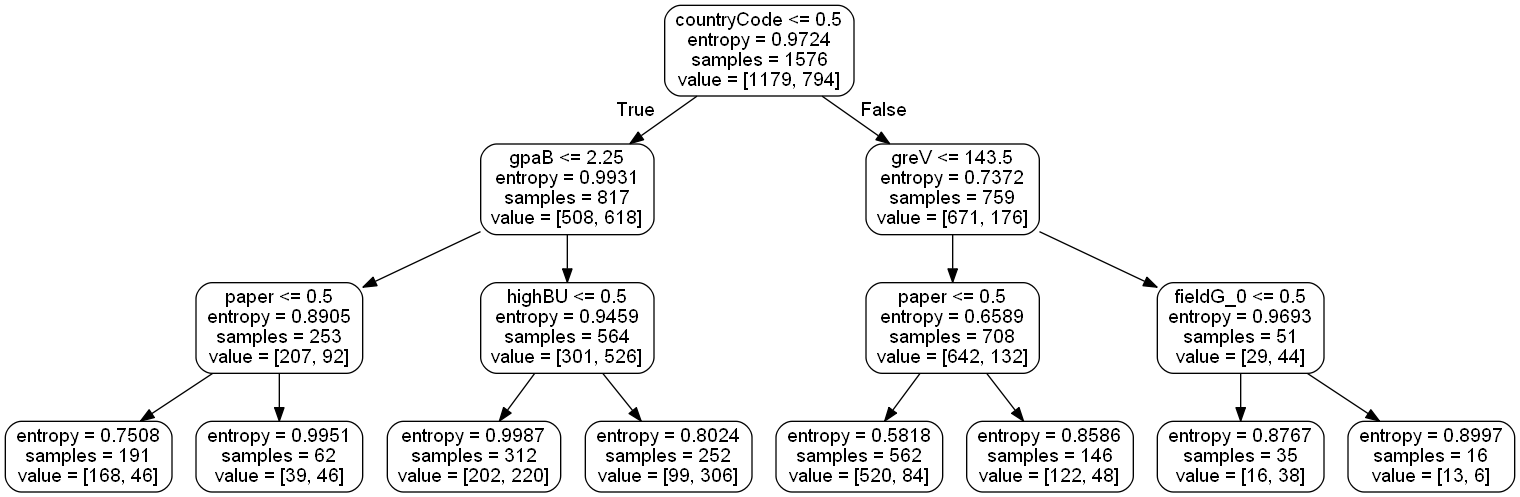

In [63]:
draw3(clf)

In [64]:
get_code(clf,col)

if ( countryCode <= 0.5 ) {
if ( gpaB <= 2.25 ) {
if ( paper <= 0.5 ) {
return [[ 168.   46.]]
} else {
return [[ 39.  46.]]
}
} else {
if ( highBU <= 0.5 ) {
return [[ 202.  220.]]
} else {
return [[  99.  306.]]
}
}
} else {
if ( greV <= 143.5 ) {
if ( paper <= 0.5 ) {
return [[ 520.   84.]]
} else {
return [[ 122.   48.]]
}
} else {
if ( fieldG_0 <= 0.5 ) {
return [[ 16.  38.]]
} else {
return [[ 13.   6.]]
}
}
}


In [65]:
confs[ac.index(max(ac))]

array([[102,  30],
       [  5,  40]])

# {0: 1, 1: 5} ACC

In [66]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:1, 1: 5})
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [67]:
[max(ac),ac.index(max(ac))]

[82.954545454545453, 10]

In [68]:
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

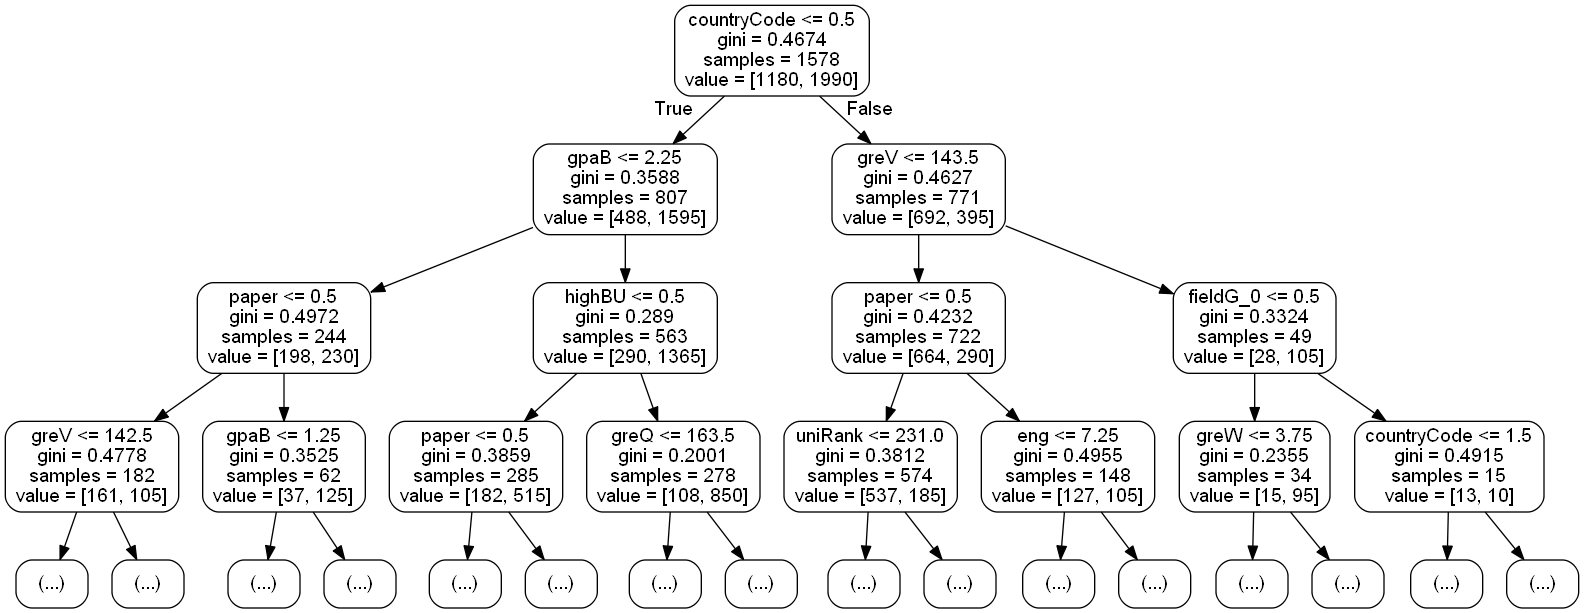

In [69]:
draw3(clf)

In [70]:
get_code(clf,col)

if ( countryCode <= 0.5 ) {
if ( gpaB <= 2.25 ) {
if ( paper <= 0.5 ) {
if ( greV <= 142.5 ) {
if ( uniRank <= 721.5 ) {
if ( eng <= 6.75 ) {
return [[ 53.   0.]]
} else {
if ( eng <= 7.75 ) {
return [[ 31.  25.]]
} else {
return [[ 41.   5.]]
}
}
} else {
if ( highBU <= 0.5 ) {
return [[ 4.  0.]]
} else {
if ( greV <= 65.0 ) {
return [[  0.  15.]]
} else {
return [[ 1.  0.]]
}
}
}
} else {
if ( uniRank <= 274.5 ) {
if ( uniRank <= 35.0 ) {
return [[ 1.  0.]]
} else {
if ( fieldG_10 <= 0.5 ) {
return [[  3.  35.]]
} else {
return [[ 1.  0.]]
}
}
} else {
if ( greQ <= 158.5 ) {
return [[ 9.  0.]]
} else {
if ( greW <= 3.25 ) {
return [[ 14.  10.]]
} else {
return [[  3.  15.]]
}
}
}
}
} else {
if ( gpaB <= 1.25 ) {
return [[ 6.  0.]]
} else {
if ( uniRank <= 312.0 ) {
if ( paper <= 2.5 ) {
if ( greV <= 133.0 ) {
return [[ 10.  20.]]
} else {
return [[ 11.   0.]]
}
} else {
if ( eng <= 6.0 ) {
return [[ 1.  0.]]
} else {
return [[  4.  45.]]
}
}
} else {
if ( uniRank <= 806.5 ) {
if ( fi

# MASTER +AUC +StratifiedKFold + BALANCED

In [71]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [72]:
[max(ac),ac.index(max(ac))]

[83.080808080808083, 0]

# MASTER +ACC +StratifiedKFold + BALANCED

In [73]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [74]:
[max(ac),ac.index(max(ac))]

[84.659090909090907, 17]

# MASTER +ACC +StratifiedKFold

In [75]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCode==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [76]:
[max(ac),ac.index(max(ac))]

[84.659090909090907, 302]

In [77]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [78]:
# draw3(clf)

In [79]:
confs[ac.index(max(ac))]

array([[123,   8],
       [ 19,  26]])

In [80]:
# get_code(clf,col)

## Sample Path

In [1]:
# # col=['countryCode', 'engCode', 'fieldGroup', 'gpaBachelors', 'gre', 
# #      'highLevelBachUni','paper','uniRank']
# me=[1,2,0,3.1,False,False,1,100]
# clf.decision_path([me]).toarray()

In [ ]:
# clf.predict([me])

In [ ]:
# clf.classes_

In [ ]:
# clf.predict_proba([me])